C:\Users\joobzm\AppData\Local\Programs\Python\Python311\Lib\pickle.py:1718: UserWarning: [18:41:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
C:\Users\joobzm\Desktop\TDK\ACPI\.venv11\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limi

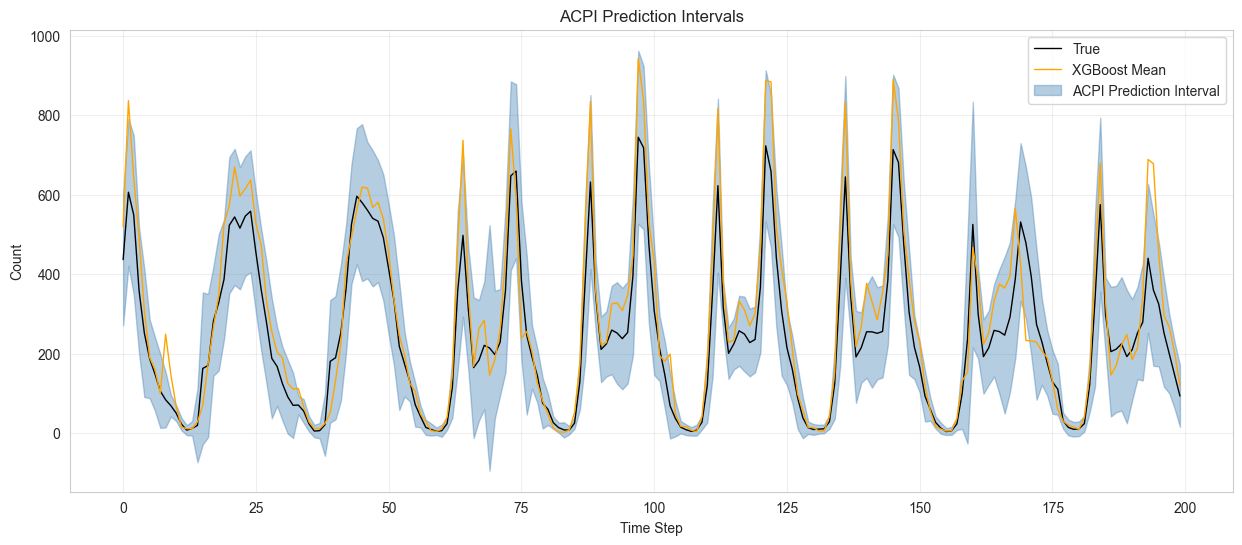

Mean Squared Error: 4562.06
Mean Absolute Error: 44.85
Root Mean Squared Error: 67.54
Mean Absolute Percentage Error: 37.47%
R^2 Score: 0.88
Coverage: 0.94


In [1]:
import numpy as np
import joblib
import xgboost as xgb

from acpi import utils


class XGBoostACPIWrapper:
    """ACPI wrapper for an XGBoost model."""

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Predict using the XGBoost model, handling DMatrix conversion."""
        dmatrix = xgb.DMatrix(X)
        return self.model.predict(dmatrix)


# load the acpi model
acpi_model = joblib.load("./models/acpi_xgboost_model_1.pkl")
DATA_TRAIN_PATH = "../data/train.csv"
DATA_TEST_PATH = "../data/test.csv"
target_col = "count"
context_length = 24
train_df = utils.read_bike_data(DATA_TRAIN_PATH)
test_df = utils.read_bike_data(DATA_TEST_PATH)
feature_cols = [c for c in train_df.columns if c != target_col and c in test_df.columns]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_cols].values.astype(np.float32))
train_target = train_df[target_col].values.astype(np.float32)

# Windowed supervised data
X_all, y_all = utils.build_lag_supervised(train_features, train_target, context_length)

# Time-ordered splits: model train / holdout
train_ratio = 0.8
n_train = int(len(X_all) * train_ratio)
X_test_hold, y_test_hold = X_all[n_train:], y_all[n_train:]

cal_size = 0.5
n_cal = int(len(X_test_hold) * cal_size)
X_test_acpi, y_test_acpi = X_test_hold[n_cal:], y_test_hold[n_cal:]

# Point predictions from the wrapped base model inside ACPI
predictions = acpi_model.model_cali.predict(X_test_acpi)
y_lower, y_upper = acpi_model.predict_pi(X_test_acpi, method='qrf')
utils.plot_acpi_predictions(predictions, y_test_acpi, y_lower, y_upper)
# Evaluate the model
mse = np.mean((predictions - y_test_acpi) ** 2)
mae = np.mean(np.abs(predictions - y_test_acpi))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((predictions - y_test_acpi) / y_test_acpi
                      )) * 100  # Mean Absolute Percentage Error
r2 = 1 - (np.sum((y_test_acpi - predictions) ** 2) / np.sum((y_test_acpi - np.mean(y_test_acpi)) ** 2))
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R^2 Score: {r2:.2f}")
# get coverage
coverage = utils.compute_coverage(y_test_acpi, y_lower, y_upper)
print(f"Coverage: {coverage:.2f}")


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SurrogateIntervalNet(nn.Module):
    """
    Differentiable surrogate for ACPI intervals.
    Predicts mu and a non-negative scale via softplus; interval = mu ± z * scale.
    """
    def __init__(self, input_dim: int, z: float, hidden: int = 256, dropout: float = 0.05):
        super().__init__()
        self.z = float(z)
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout)
        )
        self.mu_head = nn.Linear(hidden, 1)
        self.scale_head = nn.Linear(hidden, 1)  # softplus -> positive

        # Xavier init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor):
        h = self.backbone(x)
        mu = self.mu_head(h).squeeze(-1)
        scale = F.softplus(self.scale_head(h).squeeze(-1)) + 1e-6
        lo = mu - self.z * scale
        hi = mu + self.z * scale
        return mu, lo, hi

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class CoverageReducingCFGenerator:
    """
    Generates counterfactuals that reduce model coverage below a target threshold.

    The goal is to find a perturbation pattern that, when applied to test instances,
    causes the empirical coverage (1/N * sum(y_i in C(x'_i))) to drop below 1-α'.
    """

    def __init__(self, surrogate_model, acpi_model, bounds=None, mutable_idx=None, device=None):
        self.surrogate = surrogate_model
        self.acpi_model = acpi_model
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.surrogate.to(self.device).eval()

        self.bounds = bounds
        self.mutable_idx = None if mutable_idx is None else np.asarray(list(mutable_idx), dtype=int)

    @torch.no_grad()
    def _project_(self, x_t: torch.Tensor, x0_t: torch.Tensor):
        """Project back to valid space (immutable features + bounds)"""
        # Freeze immutable dims
        if self.mutable_idx is not None:
            imm_mask = torch.ones_like(x_t, dtype=torch.bool)
            imm_mask[:] = True
            imm_mask[self.mutable_idx] = False
            x_t[imm_mask] = x0_t[imm_mask]

        # Clip to bounds
        if self.bounds is not None:
            lb, ub = self.bounds
            lb_t = torch.as_tensor(lb, dtype=x_t.dtype, device=x_t.device)
            ub_t = torch.as_tensor(ub, dtype=x_t.dtype, device=x_t.device)
            x_t.clamp_(lb_t, ub_t)
        return x_t

    def compute_coverage_loss(self, X_batch, y_batch, perturbation):
        """
        Compute loss that encourages reducing coverage across the batch.

        For each (x_i, y_i), apply perturbation to get x'_i, then check if y_i ∈ C(x'_i).
        We want to minimize the number of covered instances.
        """
        batch_size = X_batch.shape[0]

        # Apply perturbation to all instances
        X_perturbed = X_batch + perturbation.unsqueeze(0).expand(batch_size, -1)

        # Get surrogate predictions for perturbed instances
        with torch.enable_grad():
            mu, lo, hi = self.surrogate(X_perturbed)

        # Check coverage for each instance
        y_batch_expanded = y_batch.unsqueeze(1) if y_batch.dim() == 1 else y_batch

        # Soft coverage indicator using sigmoid
        # If y_i is inside [lo_i, hi_i], coverage = 1; outside = 0
        # We use soft boundaries to make this differentiable
        temperature = 0.1  # Controls sharpness of sigmoid

        # Distance from interval boundaries
        below_lower = (lo - y_batch_expanded) / temperature  # positive if y < lo
        above_upper = (y_batch_expanded - hi) / temperature  # positive if y > hi

        # Probability of being covered (inside interval)
        prob_covered_lower = torch.sigmoid(-below_lower)  # 1 if y >= lo, 0 if y << lo
        prob_covered_upper = torch.sigmoid(-above_upper)  # 1 if y <= hi, 0 if y >> hi
        prob_covered = prob_covered_lower * prob_covered_upper  # both conditions

        # Coverage loss: we want to minimize coverage
        coverage_loss = torch.mean(prob_covered)

        return coverage_loss, prob_covered

    def generate_coverage_reducing_cf(
        self,
        X_test: np.ndarray,
        y_test: np.ndarray,
        target_coverage: float = 0.7,  # Target coverage (1 - α')
        steps: int = 1000,
        lr: float = 0.01,
        lam_l2: float = 0.001,
        lam_l1: float = 0.0,
        batch_size: int = 64,
        validate_every: int = 50
    ):
        """
        Generate a single perturbation pattern that reduces coverage below target.

        Args:
            X_test: Test instances to evaluate coverage on
            y_test: True labels for test instances
            target_coverage: Target coverage threshold (1 - α')
            steps: Number of optimization steps
            lr: Learning rate
            lam_l2: L2 regularization on perturbation
            lam_l1: L1 regularization on perturbation
            batch_size: Batch size for coverage evaluation
            validate_every: How often to validate against real ACPI model
        """
        self.surrogate.eval()

        X_test = np.asarray(X_test, dtype=np.float32)
        y_test = np.asarray(y_test, dtype=np.float32)
        n_test, d = X_test.shape

        # Initialize perturbation as learnable parameter
        perturbation = torch.zeros(d, dtype=torch.float32, device=self.device, requires_grad=True)
        optimizer = torch.optim.Adam([perturbation], lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.8)

        # Convert test data to tensors
        X_test_tensor = torch.from_numpy(X_test).to(self.device)
        y_test_tensor = torch.from_numpy(y_test).to(self.device)

        best_perturbation = None
        best_coverage = 1.0
        best_real_coverage = 1.0

        print(f"Target coverage: {target_coverage:.3f}")
        print(f"Initial coverage: {self._compute_real_coverage(X_test, y_test, np.zeros(d)):.3f}")

        for step in range(1, steps + 1):
            optimizer.zero_grad()

            # Sample a batch for this step
            if n_test > batch_size:
                batch_idx = np.random.choice(n_test, batch_size, replace=False)
                X_batch = X_test_tensor[batch_idx]
                y_batch = y_test_tensor[batch_idx]
            else:
                X_batch = X_test_tensor
                y_batch = y_test_tensor

            # Compute coverage loss
            coverage_loss, prob_covered = self.compute_coverage_loss(X_batch, y_batch, perturbation)

            # Regularization terms
            l2_reg = torch.sum(perturbation ** 2)
            l1_reg = torch.sum(torch.abs(perturbation))

            # Total loss: minimize coverage + regularization
            total_loss = coverage_loss + lam_l2 * l2_reg + lam_l1 * l1_reg

            total_loss.backward()

            # Zero gradients on immutable dimensions
            if self.mutable_idx is not None and perturbation.grad is not None:
                mask = torch.ones(d, device=self.device)
                mask[self.mutable_idx] = 0.0
                perturbation.grad = perturbation.grad * (1.0 - mask)

            torch.nn.utils.clip_grad_norm_([perturbation], max_norm=1.0)
            optimizer.step()

            # Project perturbation to valid space
            with torch.no_grad():
                if self.bounds is not None:
                    # We need to be more careful here - we're optimizing the perturbation,
                    # not the absolute values
                    pass  # Skip bounds projection for perturbation for now

            current_coverage = coverage_loss.item()
            scheduler.step(current_coverage)

            # Validate against real ACPI model periodically
            if (step % validate_every == 0) or (step == steps):
                pert_np = perturbation.detach().cpu().numpy()
                real_coverage = self._compute_real_coverage(X_test, y_test, pert_np)

                print(f"Step {step:4d}: Surrogate coverage={current_coverage:.3f}, "
                      f"Real coverage={real_coverage:.3f}, "
                      f"L2 norm={np.linalg.norm(pert_np):.4f}")

                # Update best if we've improved
                if real_coverage < best_real_coverage:
                    best_real_coverage = real_coverage
                    best_perturbation = pert_np.copy()

                    if real_coverage < target_coverage:
                        print(f"✓ Target coverage achieved: {real_coverage:.3f} < {target_coverage:.3f}")
                        break

        # Use best perturbation if found, otherwise final
        final_perturbation = best_perturbation if best_perturbation is not None else perturbation.detach().cpu().numpy()
        final_coverage = self._compute_real_coverage(X_test, y_test, final_perturbation)

        # Generate example counterfactual
        example_idx = 0
        x_orig = X_test[example_idx]
        x_cf = x_orig + final_perturbation

        # Project to bounds if needed
        if self.bounds is not None:
            x_cf = np.clip(x_cf, self.bounds[0], self.bounds[1])

        result = {
            "status": "success" if final_coverage < target_coverage else "partial_success",
            "perturbation": final_perturbation,
            "final_coverage": final_coverage,
            "target_coverage": target_coverage,
            "perturbation_l2": float(np.linalg.norm(final_perturbation)),
            "perturbation_l1": float(np.sum(np.abs(final_perturbation))),
            "example_x_orig": x_orig,
            "example_x_cf": x_cf,
            "example_y_true": y_test[example_idx]
        }

        return result

    def _compute_real_coverage(self, X_test, y_test, perturbation):
        """Compute real coverage using ACPI model"""
        X_perturbed = X_test + perturbation[np.newaxis, :]

        # Ensure bounds are respected
        if self.bounds is not None:
            X_perturbed = np.clip(X_perturbed, self.bounds[0], self.bounds[1])

        y_lower, y_upper = self.acpi_model.predict_pi(X_perturbed)
        covered = (y_test >= y_lower.flatten()) & (y_test <= y_upper.flatten())
        coverage = np.mean(covered)
        return coverage

    def evaluate_perturbation(self, X_test, y_test, perturbation):
        """Detailed evaluation of a perturbation on the test set"""
        X_perturbed = X_test + perturbation[np.newaxis, :]

        if self.bounds is not None:
            X_perturbed = np.clip(X_perturbed, self.bounds[0], self.bounds[1])

        # Get predictions for both original and perturbed
        y_lower_orig, y_upper_orig = self.acpi_model.predict_pi(X_test)
        y_lower_pert, y_upper_pert = self.acpi_model.predict_pi(X_perturbed)

        covered_orig = (y_test >= y_lower_orig.flatten()) & (y_test <= y_upper_orig.flatten())
        covered_pert = (y_test >= y_lower_pert.flatten()) & (y_test <= y_upper_pert.flatten())

        coverage_orig = np.mean(covered_orig)
        coverage_pert = np.mean(covered_pert)

        # Find instances that lost coverage
        lost_coverage = covered_orig & ~covered_pert

        return {
            "original_coverage": coverage_orig,
            "perturbed_coverage": coverage_pert,
            "coverage_reduction": coverage_orig - coverage_pert,
            "instances_lost_coverage": np.sum(lost_coverage),
            "fraction_lost_coverage": np.mean(lost_coverage),
            "perturbation_l2": np.linalg.norm(perturbation),
            "perturbation_l1": np.sum(np.abs(perturbation))
        }

[010] train_loss=8857.9678 val_mse(mu,lo,hi)=(4110.2812,4417.1260,6048.3281)
[020] train_loss=3313.7583 val_mse(mu,lo,hi)=(6401.2690,5284.8135,9148.7734)
[030] train_loss=2605.2527 val_mse(mu,lo,hi)=(13437.9219,9253.6094,19773.1328)
[040] train_loss=2389.6220 val_mse(mu,lo,hi)=(15765.8848,9827.5527,24599.9570)
[050] train_loss=2165.4229 val_mse(mu,lo,hi)=(17525.4141,11505.1523,26223.9395)
[060] train_loss=2123.3421 val_mse(mu,lo,hi)=(17532.4648,11039.1367,26914.7168)
Generating coverage-reducing counterfactual...
Test set size: 1087
Target coverage: 0.700
Initial coverage: 0.944
Step   50: Surrogate coverage=0.060, Real coverage=0.661, L2 norm=6.3429
✓ Target coverage achieved: 0.661 < 0.700

COVERAGE-REDUCING COUNTERFACTUAL RESULTS
Status: success
Target coverage: 0.700
Achieved coverage: 0.661
Coverage reduction: 0.339
Perturbation L2 norm: 6.3429
Perturbation L1 norm: 116.5513

DETAILED EVALUATION
Original coverage: 0.944
Perturbed coverage: 0.661
Coverage reduction: 0.283
Instances

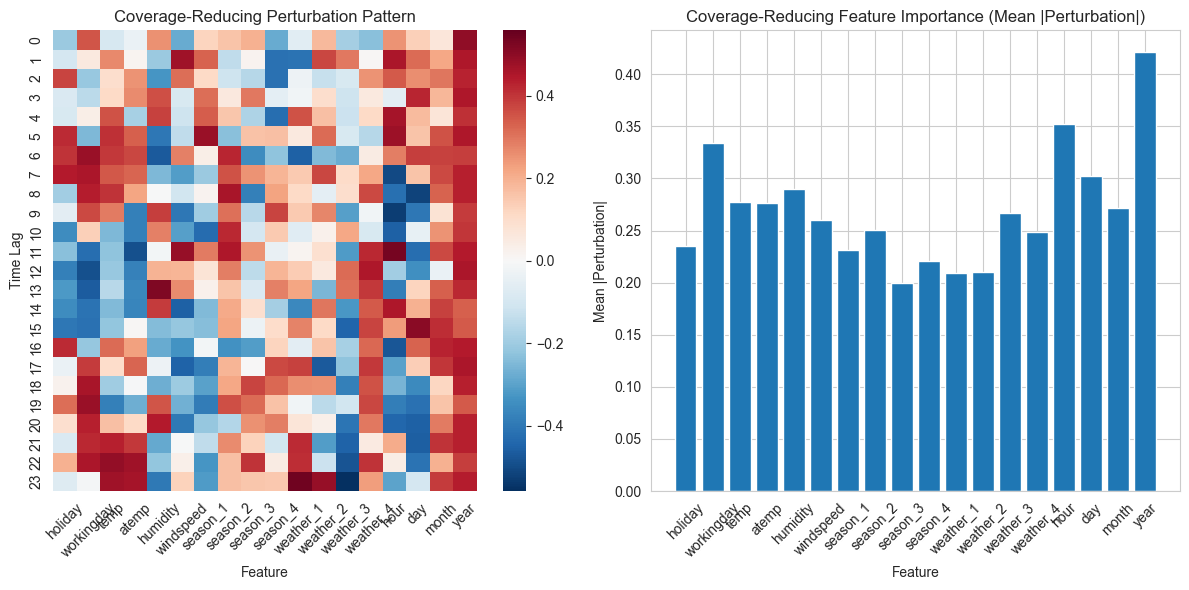


Example 1:
  True value: 520.00
  Original: pred=436.59, PI=[270.90, 602.27], covered=True
  Perturbed: pred=634.31, PI=[450.21, 818.41], covered=True
  - Still covered

Example 2:
  True value: 837.00
  Original: pred=606.32, PI=[421.06, 791.58], covered=False
  Perturbed: pred=624.78, PI=[425.61, 823.96], covered=False
  - Still uncovered

Example 3:
  True value: 642.00
  Original: pred=548.95, PI=[348.55, 749.34], covered=True
  Perturbed: pred=621.11, PI=[404.03, 838.19], covered=True
  - Still covered

TOP FEATURES BY PERTURBATION MAGNITUDE:
Rank Feature         Avg |Perturbation| Max |Perturbation|
-----------------------------------------------------------------
1    year            0.4210             0.4963            
2    hour            0.3523             0.5333            
3    workingday      0.3339             0.4922            
4    day             0.3018             0.5170            
5    humidity        0.2898             0.5198            
6    temp            0.27

In [4]:
import numpy as np
import torch

def fit_surrogate_interval_net(
    acpi_model,
    X_train: np.ndarray,
    z: float,
    val_split: float = 0.1,
    epochs: int = 50,
    batch_size: int = 256,
    lr: float = 1e-3,
    device=None
):
    """
    Supervise the surrogate to match ACPI: mu ~= point pred, lo/hi ~= predict_pi bounds.
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = np.asarray(X_train, dtype=np.float32)
    n, d = X_train.shape

    # Targets from ACPI
    mu_tgt = acpi_model.model_cali.predict(X_train).astype(np.float32).reshape(-1)
    lo_tgt, hi_tgt = acpi_model.predict_pi(X_train)
    lo_tgt = lo_tgt.astype(np.float32).reshape(-1)
    hi_tgt = hi_tgt.astype(np.float32).reshape(-1)

    # Train/val split
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_val = int(val_split * n)
    val_idx, tr_idx = idx[:n_val], idx[n_val:]

    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    mu_tr, mu_val = mu_tgt[tr_idx], mu_tgt[val_idx]
    lo_tr, lo_val = lo_tgt[tr_idx], lo_tgt[val_idx]
    hi_tr, hi_val = hi_tgt[tr_idx], hi_tgt[val_idx]

    ds_tr = torch.utils.data.TensorDataset(
        torch.from_numpy(X_tr), torch.from_numpy(mu_tr), torch.from_numpy(lo_tr), torch.from_numpy(hi_tr)
    )
    dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=batch_size, shuffle=True)

    net = SurrogateIntervalNet(input_dim=d, z=z).to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.7)

    def eval_mse(Xv, muv, lov, hiv):
        with torch.no_grad():
            Xt = torch.from_numpy(Xv).to(device)
            mu, lo, hi = net(Xt)
            m = torch.mean((mu - torch.from_numpy(muv).to(device)) ** 2).item()
            l = torch.mean((lo - torch.from_numpy(lov).to(device)) ** 2).item()
            h = torch.mean((hi - torch.from_numpy(hiv).to(device)) ** 2).item()
            return m, l, h

    for ep in range(epochs):
        net.train()
        loss_sum = 0.0
        for xb, mu_b, lo_b, hi_b in dl_tr:
            xb = xb.to(device)
            mu_b = mu_b.to(device)
            lo_b = lo_b.to(device)
            hi_b = hi_b.to(device)

            opt.zero_grad()
            mu_p, lo_p, hi_p = net(xb)
            # Weighted MSE on mu/lo/hi
            loss = (
                torch.mean((mu_p - mu_b) ** 2) * 1.0 +
                torch.mean((lo_p - lo_b) ** 2) * 0.5 +
                torch.mean((hi_p - hi_b) ** 2) * 0.5
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=5.0)
            opt.step()
            loss_sum += loss.item()

        m, l, h = eval_mse(X_val, mu_val, lo_val, hi_val)
        sched.step(m + l + h)
        if (ep + 1) % 10 == 0:
            print(f"[{ep+1:03d}] train_loss={loss_sum/len(dl_tr):.4f} val_mse(mu,lo,hi)=({m:.4f},{l:.4f},{h:.4f})")
    net.eval()
    return net

# --- Example usage in your notebook context ---

# 1) Build train slice used to fit the surrogate (same space as ACPI inputs)
X_train_acpi = X_all[:n_train]

# 2) Compute z from alpha used by ACPI intervals (alpha=0.1 => z~1.645)
import scipy.stats as _scistats
alpha = 0.1
z = float(_scistats.norm.ppf(1 - alpha / 2.0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
surrogate = fit_surrogate_interval_net(
    acpi_model=acpi_model,
    X_train=X_train_acpi,
    z=z,
    epochs=60,
    batch_size=512,
    lr=1e-3,
    device=device
)

# 3) Bounds from train percentiles (model input space)
lb = np.percentile(X_train_acpi, 1, axis=0)
ub = np.percentile(X_train_acpi, 99, axis=0)
eps = 1e-6
span = np.maximum(ub - lb, eps)
lb = (lb - 0.05 * span).astype(np.float32)
ub = (ub + 0.05 * span).astype(np.float32)

# 4) Pick a covered instance to explain
y_lo_test, y_hi_test = acpi_model.predict_pi(X_test_acpi)
inside = np.where((y_test_acpi >= y_lo_test) & (y_test_acpi <= y_hi_test))[0]
assert inside.size > 0, "No covered instances found."
idx = int(inside[0])
x0 = X_test_acpi[idx]
y_true = float(y_test_acpi[idx])

# Initialize the coverage-reducing CF generator
coverage_cf_gen = CoverageReducingCFGenerator(
    surrogate_model=surrogate,
    acpi_model=acpi_model,
    bounds=(lb, ub),
    mutable_idx=None,  # Allow all features to be modified
    device=device
)

# Set target coverage (1 - α')
# For example, if current coverage is ~90% and we want to reduce it to 70%
target_coverage = 0.70

print(f"Generating coverage-reducing counterfactual...")
print(f"Test set size: {len(X_test_acpi)}")

# Generate the coverage-reducing perturbation
coverage_result = coverage_cf_gen.generate_coverage_reducing_cf(
    X_test=X_test_acpi,
    y_test=y_test_acpi,
    target_coverage=target_coverage,
    steps=800,
    lr=0.02,
    lam_l2=0.001,
    lam_l1=0.0,
    batch_size=64,
    validate_every=50
)

print(f"\n{'=' * 60}")
print(f"COVERAGE-REDUCING COUNTERFACTUAL RESULTS")
print(f"{'=' * 60}")
print(f"Status: {coverage_result['status']}")
print(f"Target coverage: {coverage_result['target_coverage']:.3f}")
print(f"Achieved coverage: {coverage_result['final_coverage']:.3f}")
print(f"Coverage reduction: {1.0 - coverage_result['final_coverage']:.3f}")
print(f"Perturbation L2 norm: {coverage_result['perturbation_l2']:.4f}")
print(f"Perturbation L1 norm: {coverage_result['perturbation_l1']:.4f}")

evaluation = coverage_cf_gen.evaluate_perturbation(
    X_test_acpi,
    y_test_acpi,
    coverage_result['perturbation']
)

print(f"\n{'=' * 60}")
print(f"DETAILED EVALUATION")
print(f"{'=' * 60}")
print(f"Original coverage: {evaluation['original_coverage']:.3f}")
print(f"Perturbed coverage: {evaluation['perturbed_coverage']:.3f}")
print(f"Coverage reduction: {evaluation['coverage_reduction']:.3f}")
print(f"Instances that lost coverage: {evaluation['instances_lost_coverage']}")
print(f"Fraction that lost coverage: {evaluation['fraction_lost_coverage']:.3f}")

import matplotlib.pyplot as plt


def plot_perturbation_pattern(perturbation, context_length, feature_names=None, title_prefix=""):
    """Visualize the learned perturbation pattern."""
    pert = np.asarray(perturbation).reshape(-1)

    if len(pert) % context_length == 0:
        base_dim = len(pert) // context_length
        if feature_names is None:
            feature_names = [f"f{j}" for j in range(base_dim)]

        pert_reshaped = pert.reshape(context_length, base_dim)

        # Heatmap of perturbation
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        import seaborn as sns
        v = np.max(np.abs(pert_reshaped))
        sns.heatmap(pert_reshaped, cmap="RdBu_r", center=0, vmin=-v, vmax=v)
        plt.title(f"{title_prefix}Perturbation Pattern")
        plt.xlabel("Feature")
        plt.ylabel("Time Lag")
        plt.xticks(np.arange(base_dim) + 0.5, feature_names, rotation=45)

        # Feature importance (mean absolute perturbation over time)
        plt.subplot(1, 2, 2)
        feature_importance = np.mean(np.abs(pert_reshaped), axis=0)
        plt.bar(range(base_dim), feature_importance)
        plt.title(f"{title_prefix}Feature Importance (Mean |Perturbation|)")
        plt.xlabel("Feature")
        plt.ylabel("Mean |Perturbation|")
        plt.xticks(range(base_dim), feature_names, rotation=45)

        plt.tight_layout()
        plt.show()
    else:
        # Flat visualization
        plt.figure(figsize=(12, 4))
        plt.plot(pert, 'o-', alpha=0.7)
        plt.title(f"{title_prefix}Perturbation Pattern (Flat)")
        plt.xlabel("Dimension")
        plt.ylabel("Perturbation Value")
        plt.axhline(0, color='k', linestyle='--', alpha=0.5)
        plt.grid(True, alpha=0.3)
        plt.show()


# Visualize the learned perturbation
plot_perturbation_pattern(
    coverage_result['perturbation'],
    context_length,
    feature_cols,
    "Coverage-Reducing "
)


def show_example_transformations(X_test, y_test, perturbation, acpi_model, n_examples=3):
    """Show how the perturbation affects individual instances."""

    for i in range(min(n_examples, len(X_test))):
        x_orig = X_test[i]
        x_pert = x_orig + perturbation
        y_true = y_test[i]

        # Clip to bounds if needed
        if hasattr(coverage_cf_gen, 'bounds') and coverage_cf_gen.bounds is not None:
            x_pert = np.clip(x_pert, coverage_cf_gen.bounds[0], coverage_cf_gen.bounds[1])

        # Get predictions
        pred_orig = acpi_model.model_cali.predict(x_orig.reshape(1, -1))[0]
        lo_orig, hi_orig = acpi_model.predict_pi(x_orig.reshape(1, -1))

        pred_pert = acpi_model.model_cali.predict(x_pert.reshape(1, -1))[0]
        lo_pert, hi_pert = acpi_model.predict_pi(x_pert.reshape(1, -1))

        # Check coverage
        covered_orig = lo_orig[0] <= y_true <= hi_orig[0]
        covered_pert = lo_pert[0] <= y_true <= hi_pert[0]

        print(f"\nExample {i + 1}:")
        print(f"  True value: {y_true:.2f}")
        print(f"  Original: pred={pred_orig:.2f}, PI=[{lo_orig[0]:.2f}, {hi_orig[0]:.2f}], covered={covered_orig}")
        print(f"  Perturbed: pred={pred_pert:.2f}, PI=[{lo_pert[0]:.2f}, {hi_pert[0]:.2f}], covered={covered_pert}")

        if covered_orig and not covered_pert:
            print(f"  ✓ Lost coverage (success)")
        elif not covered_orig and covered_pert:
            print(f"  ⚠ Gained coverage (unexpected)")
        elif covered_orig and covered_pert:
            print(f"  - Still covered")
        else:
            print(f"  - Still uncovered")


show_example_transformations(X_test_acpi, y_test_acpi, coverage_result['perturbation'], acpi_model)


def analyze_perturbation_effects(perturbation, context_length, feature_names=None):
    """Analyze which features and time lags contribute most to the perturbation."""

    pert = np.asarray(perturbation).reshape(-1)

    if len(pert) % context_length == 0:
        base_dim = len(pert) // context_length
        if feature_names is None:
            feature_names = [f"f{j}" for j in range(base_dim)]

        pert_reshaped = pert.reshape(context_length, base_dim)

        # Feature-wise analysis
        feature_effects = np.mean(np.abs(pert_reshaped), axis=0)
        feature_ranking = np.argsort(feature_effects)[::-1]

        print(f"\nTOP FEATURES BY PERTURBATION MAGNITUDE:")
        print(f"{'Rank':<4} {'Feature':<15} {'Avg |Perturbation|':<18} {'Max |Perturbation|':<18}")
        print("-" * 65)

        for rank, feat_idx in enumerate(feature_ranking[:10]):  # Top 10
            avg_pert = feature_effects[feat_idx]
            max_pert = np.max(np.abs(pert_reshaped[:, feat_idx]))
            print(f"{rank + 1:<4} {feature_names[feat_idx]:<15} {avg_pert:<18.4f} {max_pert:<18.4f}")

        # Time lag analysis
        time_effects = np.mean(np.abs(pert_reshaped), axis=1)
        print(f"\nTIME LAG ANALYSIS:")
        print(f"{'Lag':<4} {'Avg |Perturbation|':<18}")
        print("-" * 25)

        for t in range(context_length):
            print(f"{t:<4} {time_effects[t]:<18.4f}")

    return pert


analyze_perturbation_effects(coverage_result['perturbation'], context_length, feature_cols)

import joblib

# Save the perturbation pattern and results
results_to_save = {
    'perturbation': coverage_result['perturbation'],
    'coverage_results': coverage_result,
    'evaluation': evaluation,
    'feature_names': feature_cols,
    'context_length': context_length,
    'target_coverage': target_coverage
}

# Uncomment to save:
# joblib.dump(results_to_save, 'coverage_reducing_cf_results.pkl')
# print("Results saved to 'coverage_reducing_cf_results.pkl'")

print(f"\n{'=' * 60}")
print(f"SUMMARY")
print(f"{'=' * 60}")
if coverage_result['status'] == 'success':
    print(
        f"✅ Successfully reduced coverage from {evaluation['original_coverage']:.3f} to {evaluation['perturbed_coverage']:.3f}")
    print(f"📉 Coverage reduction: {evaluation['coverage_reduction']:.3f}")
    print(f"🎯 Target achieved: {evaluation['perturbed_coverage']:.3f} < {target_coverage:.3f}")
else:
    print(f"⚠️  Partial success: Reduced coverage to {evaluation['perturbed_coverage']:.3f}")
    print(f"🎯 Target: {target_coverage:.3f} (not fully achieved)")

print(f"🔧 Perturbation magnitude (L2): {coverage_result['perturbation_l2']:.4f}")
print(f"📊 {evaluation['instances_lost_coverage']} out of {len(y_test_acpi)} instances lost coverage")